In [1]:
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import sklearn.metrics as sklm

sys.path.insert(0, '/work/scripts/')

from util.output import load_trsc_dataframe

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def temp_interp(time1, time2, T, L, Dnew):

    '''
    Example code for testing:
    
    VAR = 'TLAYER'
    depth = (0.02 + 0.005)/2
    
    date_start = pd.to_datetime("2010")
    date_end = pd.to_datetime("2015")
    
    plt.plot(layer_data[VAR][0][date_start:date_end][0])
    plt.plot(layer_data[VAR][0][date_start:date_end][1])
    
    T_interp = temp_interp(date_start,date_end, layer_data[VAR][0], 
                           (layer_data['LAYERDEPTH'][0]+0.5*layer_data['LAYERDZ'][0]), 
                           depth)    
    
    plt.plot(T_interp)

    '''

    LD = L.mean()

    idx = find_nearest(LD, Dnew)
    if Dnew < LD[idx]:
        idx1 = idx-1; idx2 = idx
    else:
        idx1 = idx; idx2 = idx+1

    D1 = LD[idx1]; D2 = LD[idx2]
    T1 = T[idx1]; T2 = T[idx2]

    temp_list = []
    for i in range (0, len(T1[time1:time2])):
        temp_list.append(np.interp(Dnew, [D1, D2], [T1[time1:time2][i], T2[time1:time2][i]]))
    temp_new = pd.DataFrame(index=T1[time1:time2].index, data=temp_list)
    return temp_new

def seasonal_profile(VAR, depth, thickness, resolution, time_range, months, x):
    '''
    VAR : variable dataframe
    depth : associated LAYERDEPTH dataframe
    thickness : associated LAYERDZ dataframe
    resolution : total number of points to interpolate through soil column
    time_range : time period to be calculated over (e.g. '2011-2021')
    months : months included in calculation - ['Jan', 'Feb', 'Dec'] (e.g winter season)
    '''
    month_range = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # startyr, endyr = time_range[0], time_range[1]

    #Setting time range    
    range_series = VAR[startyr:endyr]
    LD = depth[startyr:endyr]
    LZ = thickness[startyr:endyr]

    #Seasonal exclusion
    range_series = range_series[range_series.index.month.isin([i+1 for i, e in enumerate(month_range) if e in months])]
    LD = (LD[LD.index.month.isin([i+1 for i, e in enumerate(month_range) if e in months])]).mean()
    LZ = (LZ[LZ.index.month.isin([i+1 for i, e in enumerate(month_range) if e in months])]).mean()
    mean = range_series.mean().values.tolist()
        
    maxi = range_series.max().values.tolist()
    mini = range_series.min().values.tolist()
    std =  range_series.std().values.tolist()

    xp = (LD + LZ/2).values.tolist()
    
    indexes = [i for i,v in enumerate(xp) if v < 0]

    for index in sorted(indexes, reverse=True):
        del xp[index]
        del mean[index]
        del mini[index]
        del maxi[index]
        del std[index]

    interp_mean=np.interp(x,xp,mean)
    interp_mini=np.interp(x,xp,mini)
    interp_maxi=np.interp(x,xp,maxi)
    interp_std=np.interp(x,xp,std)
    
    return x,interp_mean, interp_std, interp_mini, interp_maxi

In [2]:
from scipy.interpolate import interp1d

def soil_contourbydepth(df, df_depth, df_dz, start_time=None, end_time=None, 
                  depth_start=None, depth_end=None, n=100, zero=False, ylim=False, col_bar_label='Temperature [$\^circ$C]'):
    '''
    data_path: path to output data to plot
    output_var: variable to plot (technically, doesn't need to be temperature)
    res: time resolution of output data
    px, py: pixel location of data
    output_folder: name of output folder
    start_time, end_time: start and end year of data to plot
    depth_start, depth_end: starting and ending depth to be plotted (in meters)
    n: levels on the colobar
    '''
#     df = interp_var
#     df_depth = depth
#     df_
#     df_depth, meta_depth = load_trsc_dataframe(var='LAYERDEPTH',  timeres=res, px_y=py, px_x=px, fileprefix=data_path+'/'+output_folder)
#     df_dz, meta_dzh = load_trsc_dataframe(var='LAYERDZ',  timeres=res, px_y=py, px_x=px, fileprefix=data_path+'/'+output_folder)
    
    layers = df.columns.astype(float)
    times = pd.to_datetime(df.index)
    
    # Filter data based on start_time and end_time
    if start_time is not None and end_time is not None:
        mask = (times >= start_time) & (times <= end_time)
        df = df.loc[mask]
        times = times[mask]

    # Extract necessary data
    depths = df_depth.iloc[:, :-2].values
    dz = df_dz.iloc[:, :-2].values
    temperature = df.iloc[:, :-2].values
    xp = depths + dz / 2  # Center of each layer, x-coordinates of the data points for interp1d

    # Create a regular grid of depth values
    ii=np.unravel_index(np.argmax(depths), depths.shape)
    maxd=depths.max()+(dz[ii]/2)
    regular_depths = np.arange(0, maxd, 0.01)

    # Interpolate temperature onto the regular grid
    interp_temperature = np.empty((temperature.shape[0], regular_depths.shape[0]))
    for i in range(temperature.shape[0]):
        f = interp1d(xp[i], temperature[i], kind='linear', fill_value='extrapolate')
        interp_temperature[i] = f(regular_depths)

    # Create contour plot
    color_axes = max(np.max(temperature), np.abs(np.min(temperature)))
    plt.contourf(times, regular_depths, interp_temperature.T, cmap='seismic', vmin=-color_axes, vmax=color_axes, levels=n)

    # Add colorbar
    plt.colorbar(label=col_bar_label)

    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Depth (m)')

    # Show the plot
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    else:
        plt.ylim(depth_start, depth_end)
        
    
    df_interp = pd.DataFrame(index=times, columns=regular_depths, data=interp_temperature)

    if zero:
        plt.contour(times, regular_depths, interp_temperature.T, colors=('k',), linewidths=(1,), levels=zero)

    plt.gca().invert_yaxis()
    
    return df_interp

In [3]:
def soil_contourbydepth_diff(df, df_depth, df_dz, df_diff=None, df_depth_diff=None, df_dz_diff=None,
                             start_time=None, end_time=None,
                             depth_start=None, depth_end=None,
                             n=100, zero=False, ylim=False, 
                             col_bar_label='Temperature [$\^circ$C]'):
    '''
    data_path: path to output data to plot
    output_var: variable to plot (technically, doesn't need to be temperature)
    res: time resolution of output data
    px, py: pixel location of data
    output_folder: name of output folder
    start_time, end_time: start and end year of data to plot
    depth_start, depth_end: starting and ending depth to be plotted (in meters)
    n: levels on the colobar
    '''
    
    layers = df.columns.astype(float)
    layers_diff = df_diff.columns.astype(float)
    
    times = pd.to_datetime(df.index)
    times_diff = pd.to_datetime(df_diff.index)
        
    # Filter data based on start_time and end_time
    if start_time is not None and end_time is not None:
        mask = (times >= start_time) & (times <= end_time)
        df = df.loc[mask]; df_diff = df_diff.loc[mask]
        times = times[mask]

    # Extract necessary data
    depths = df_depth.iloc[:, :-2].values; depths_diff = df_depth_diff.iloc[:, :-2].values
    dz = df_dz.iloc[:, :-2].values; dz_diff = df_dz_diff.iloc[:, :-2].values
    temperature = df.iloc[:, :-2].values; temperature_diff = df_diff.iloc[:, :-2].values
    xp = depths + dz / 2  # Center of each layer, x-coordinates of the data points for interp1d
    xp_diff = depths_diff + dz_diff / 2
    
    # Create a regular grid of depth values
    ii=np.unravel_index(np.argmax(depths), depths.shape)
    maxd=depths.max()+(dz[ii]/2)
    regular_depths = np.arange(0, maxd, 0.01)

    ii_diff=np.unravel_index(np.argmax(depths_diff), depths_diff.shape)
    maxd_diff=depths_diff.max()+(dz_diff[ii]/2)
    regular_depths_diff = np.arange(0, maxd_diff, 0.01)

    # Interpolate temperature onto the regular grid
    interp_temperature = np.empty((temperature.shape[0], regular_depths.shape[0]))
    for i in range(temperature.shape[0]):
        f = interp1d(xp[i], temperature[i], kind='linear', fill_value='extrapolate')
        interp_temperature[i] = f(regular_depths)

    interp_temperature_diff = np.empty((temperature_diff.shape[0], regular_depths.shape[0]))
    for i in range(temperature_diff.shape[0]):
        f = interp1d(xp_diff[i], temperature_diff[i], kind='linear', fill_value='extrapolate')
        interp_temperature_diff[i] = f(regular_depths)

    # Create contour plot
    color_axes = max(np.max(interp_temperature_diff.T - interp_temperature.T), np.abs(np.min(interp_temperature_diff.T - interp_temperature.T)))
    plt.contourf(times, regular_depths, interp_temperature_diff.T - interp_temperature.T, cmap='seismic', vmin=-color_axes, vmax=color_axes, levels=n)

    # Add colorbar
    plt.colorbar(label=col_bar_label)

    # Set labels and title
    plt.xlabel('Time')
    plt.ylabel('Depth (m)')

    # Show the plot
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    else:
        plt.ylim(depth_start, depth_end)
        
    
    df_interp = pd.DataFrame(index=times, columns=regular_depths, data=interp_temperature_diff - interp_temperature)

    if zero:
        plt.contour(times, regular_depths, interp_temperature.T, colors=('k',), linewidths=(1,), levels=[0])

    plt.gca().invert_yaxis()
    
    return df_interp

In [105]:
base_dir = "/data/workflows/"

f_dir = [
    'reference',
    'unfrozen_water',
]

f_name = [
    'Master',
    'Unfrozen water'
    ]

In [140]:
units = {}; monthly = {} ; yearly = {}
py = 0; px = 0

yearly_vars = ["ALD"]
monthly_vars = ["GPP", "RH", "RG", 'WATERTAB', 'SNOWTHICK', 'EET', 'PET', 'TRANSPIRATION']
layer_vars = ["LAYERDZ", "LAYERDEPTH", "LAYERTYPE", "LWCLAYER", "IWCLAYER", "TLAYER", "TCLAYER", 'FRONTSTYPE','FRONTSDEPTH']
layer_data = {key: [] for key in layer_vars}
soil_vars = ["ground", "moss", "shlw", "deep", "mine"]
soil_profiles = {key: [] for key in soil_vars}

for i, DIR in enumerate(f_dir):
    
    df = pd.DataFrame() 
    
    for VAR in yearly_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='yearly', px_y=py,
                                       px_x=px, fileprefix=f'{base_dir+DIR}/output')
        if dfa.columns.stop>1:
            dfa = pd.DataFrame(dfa.sum(axis=1))
        dfa.columns = [VAR];df = pd.concat([df,dfa], axis=1)
        
        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
        
    yearly[f_name[i]] = df
    
    df = pd.DataFrame()
    
    for VAR in monthly_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='monthly', px_y=py,
                                       px_x=px, fileprefix=f'{base_dir+DIR}/output')
        if dfa.columns.stop>1:
            dfa = pd.DataFrame(dfa.sum(axis=1))
        dfa.columns = [VAR];df = pd.concat([df,dfa], axis=1)

        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
        
    monthly[f_name[i]] = df
    
    for VAR in layer_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='monthly', px_y=py,
                                       px_x=px, fileprefix=f'{base_dir+DIR}/output')
        layer_data[VAR] += [dfa]

        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
            
    ground = layer_data["LAYERDEPTH"][i][0]        
    soil_profiles["ground"] += [pd.DataFrame({"ground":ground})]
    
    moss = ground - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==0], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["moss"] += [pd.DataFrame({"moss":moss})]
    
    shlw = moss - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==1], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["shlw"] += [pd.DataFrame({"shlw":shlw})]
    
    deep = shlw - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==2], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["deep"] += [pd.DataFrame({"deep":deep})]
    
    mine = deep - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==3], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["mine"] += [pd.DataFrame({"mine":mine})]

Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/ALD_yearly_tr.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/ALD_yearly_sc.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/GPP_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/GPP_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/RH_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/RH_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/RG_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/RG_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/WATERTAB_monthly_tr.nc
Trying to open:  /data/workflows/latent_heat/bzb/september_review/ref/output/WATERTAB_monthly_sc.nc
Trying to open:  /data/workflows/latent_heat/b

Master: 6.416885033947135
Unfrozen water: 5.840518550728441
Unfrozen water test: 6.500994359659708


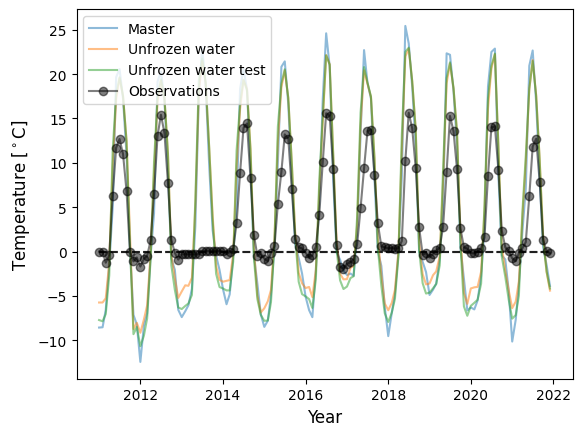

In [144]:
VAR = 'TLAYER'
depth = 0.02

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

date_start=pd.to_datetime("2010-01-01")
date_end=pd.to_datetime("2015-01-01")

for i, name in enumerate(f_name):

    T_interp = temp_interp(date_start,date_end, layer_data[VAR][i], 
                           (layer_data['LAYERDEPTH'][i]+0.5*layer_data['LAYERDZ'][i]), 
                           depth)
    
    ax.plot(layer_data[VAR][i][date_start:date_end][0].index, np.zeros(len(layer_data[VAR][0][date_start:date_end][0])), 'k--', alpha=0.5)
    ax.set_ylabel('Temperature [$^\circ$C]', fontsize=12)
    ax.set_xlabel('Year', fontsize=12)
    ax.plot(T_interp, alpha = 0.5, label=name)

ax.legend(loc='upper left',fontsize=10)

Master: 7.63974448827767
Unfrozen water: 10.037566027479908
Unfrozen water test: 10.959363212309983


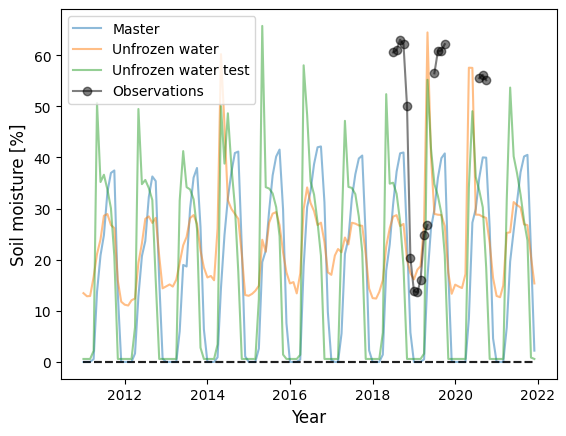

In [153]:
VAR = 'LWCLAYER'
depth = 0.02

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

date_start=pd.to_datetime("2010-01-01")
date_end=pd.to_datetime("2015-01-01")

for i, name in enumerate(f_name):

    T_interp = 100*temp_interp(date_start,date_end, layer_data[VAR][i], 
                           (layer_data['LAYERDEPTH'][i]+0.5*layer_data['LAYERDZ'][i]), 
                           depth)
        
    ax.plot(layer_data[VAR][i][date_start:date_end][0].index, np.zeros(len(layer_data[VAR][0][date_start:date_end][0])), 'k--', alpha=0.5)
    ax.set_ylabel('Soil moisture [%]', fontsize=12)
    ax.set_xlabel('Year', fontsize=12)
    ax.plot(T_interp, alpha = 0.5, label=name)

ax.legend(loc='upper left', fontsize=10)

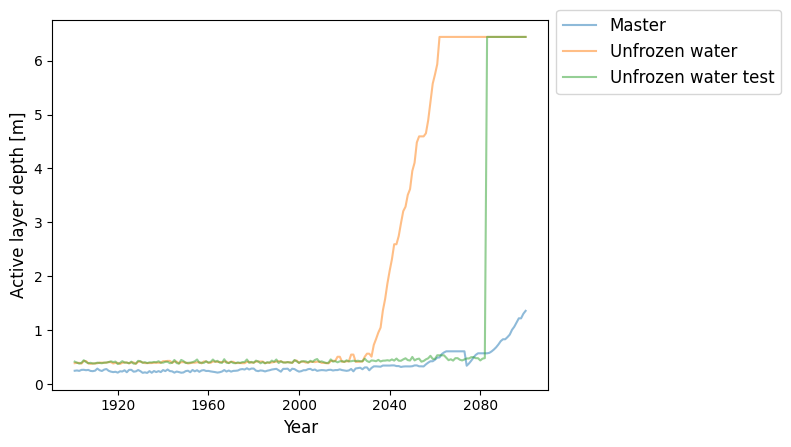

In [160]:
VAR = 'ALD'

date_start = pd.to_datetime("1901")
date_end = pd.to_datetime("2100")

for i, name in enumerate(f_name):
    plt.plot(yearly[name][VAR][date_start:date_end], alpha = 0.5, label=name)

plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel(f"Active layer depth [{units['ALD']}]", fontsize=12)

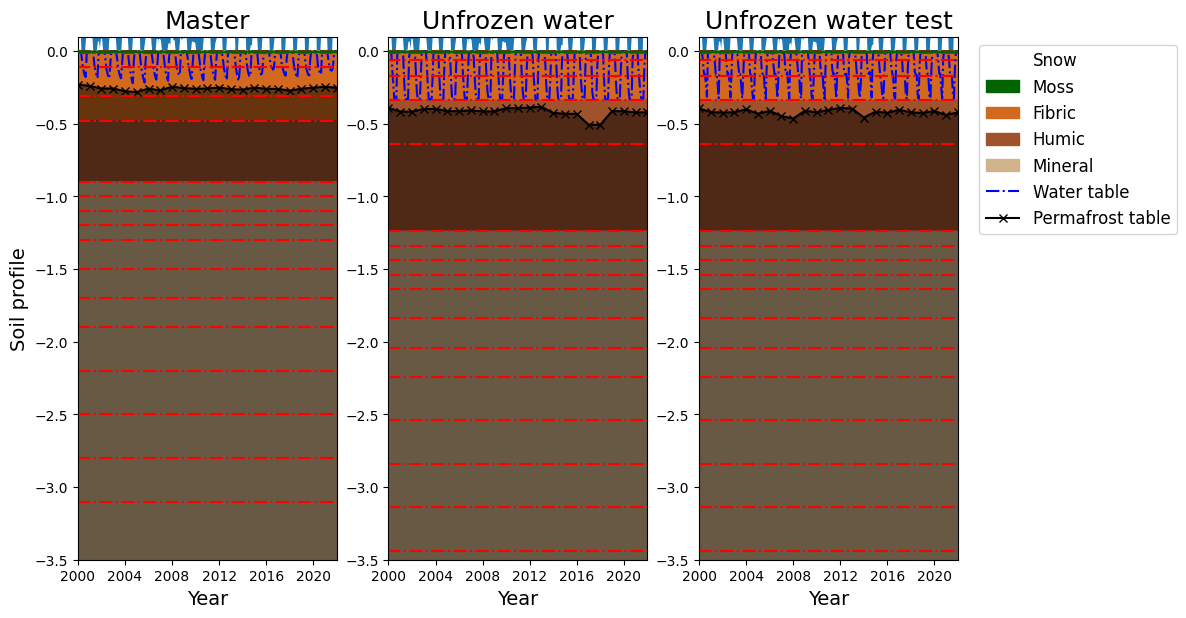

In [162]:
ymin = -3.5;  ymax = 0.1
xmin = pd.to_datetime("2010");  xmax = pd.to_datetime("2015")

fig, axis = plt.subplots(1, len(f_name))

for i, run in enumerate(f_name):
    
    ax = axis[i]
        
    ax.set_facecolor('C0')
    
    ax.fill_between(monthly[run]["SNOWTHICK"].index, np.zeros(len(monthly[run]["SNOWTHICK"])), 
                    monthly[run]["SNOWTHICK"], color='white', label="Snow")
    
    ax.fill_between(soil_profiles["moss"][i].index, soil_profiles["moss"][i]["moss"], 
                    soil_profiles["ground"][i]["ground"],color="darkgreen", label='Moss', zorder=5)
    
    ax.fill_between(soil_profiles["shlw"][i].index, soil_profiles["shlw"][i]["shlw"], 
                    soil_profiles["moss"][i]["moss"],color="chocolate", label='Fibric')
    
    ax.fill_between(soil_profiles["deep"][i].index, soil_profiles["deep"][i]["deep"], 
                    soil_profiles["shlw"][i]["shlw"],color="sienna", label="Humic")
    
    ax.fill_between(soil_profiles["mine"][i].index, soil_profiles["mine"][i]["mine"], 
                    soil_profiles["deep"][i]["deep"],color="tan", label='Mineral')
    
    ax.plot(monthly[run]["WATERTAB"].index, -monthly[run]["WATERTAB"], 'b-.', label="Water table")
    
    ax.plot(yearly[run]["ALD"].index, -yearly[run]["ALD"], 'k-x', label="Permafrost table")
    ax.fill_between(yearly[run]["ALD"].index, -10 * np.ones(len(yearly[run]["ALD"])), -yearly[run]["ALD"], 
                    color='k', alpha=0.5)

    ax.plot(-layer_data['LAYERDEPTH'][i], 'r-.')
    

    
    ax.set_title(f_name[i], fontsize=18)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('Year', fontsize=14)
    if i == 0:
        ax.set_ylabel('Soil profile', fontsize=14)
    
    
        
handles, labels = plt.gca().get_legend_handles_labels()

ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=12)
        
plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.2, wspace=None, hspace=None)

Text(0.5, 1.0, 'Difference in temperature')

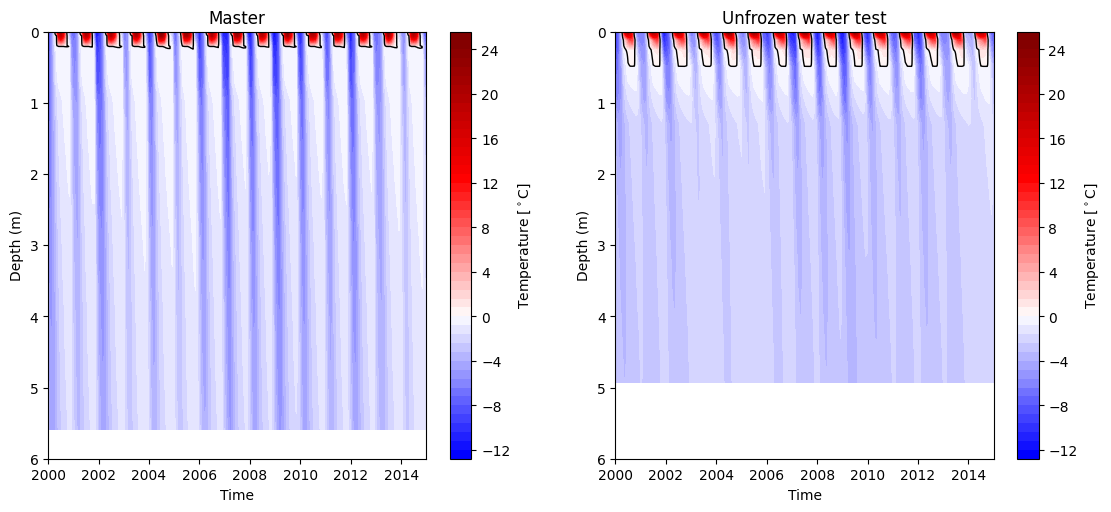

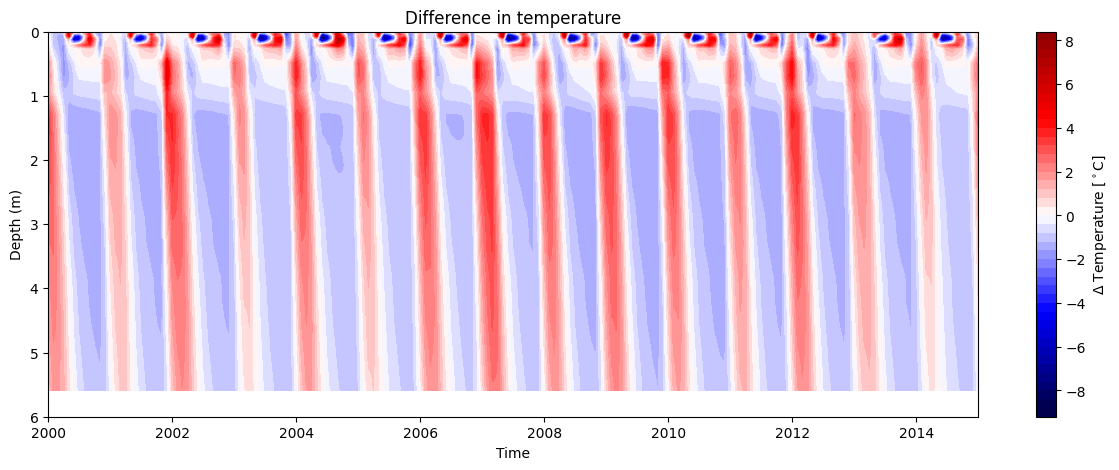

In [129]:
i = 0; var = "TLAYER"; start='2010'; end='2015'; N=50; D1=0;D2=6; Z=[0]; Y=False;

fig = plt.figure()
ax = fig.add_subplot(121)

ref_interp_T = soil_contourbydepth(df = layer_data[var][i], df_depth = layer_data["LAYERDEPTH"][i], df_dz = layer_data["LAYERDZ"][i],
                                 start_time=start, end_time=end, depth_start=D1, depth_end=D2, n=N, zero=Z, ylim=Y,col_bar_label='Temperature [$^\circ$C]')

plt.title(f'{f_name[i]}')
ax = fig.add_subplot(122)

j = 1
unf_interp_T = soil_contourbydepth(df = layer_data[var][j], df_depth = layer_data["LAYERDEPTH"][j], df_dz = layer_data["LAYERDZ"][j],
                                 start_time=start, end_time=end, depth_start=D1, depth_end=D2, n=N, zero=Z, ylim=Y,col_bar_label='Temperature [$^\circ$C]')
plt.title(f'{f_name[j]}')
plt.subplots_adjust(left=None, bottom=None, right=1.75, top=1, wspace=None, hspace=None)
# plt.show

# plt.savefig('/data/workflows/temp_profiles_comp.png', bbox_inches='tight')


fig, ax = plt.subplots(1,1,figsize=(15, 5))
unfroz_interp = soil_contourbydepth_diff(df = layer_data[var][i], df_depth = layer_data["LAYERDEPTH"][i], df_dz = layer_data["LAYERDZ"][i],
                                         df_diff = layer_data[var][j], df_depth_diff = layer_data["LAYERDEPTH"][j], df_dz_diff = layer_data["LAYERDZ"][j],
                                         start_time=start, end_time=end, depth_start=D1, depth_end=D2, n=N, zero=False, ylim=Y,col_bar_label='$\Delta$ Temperature [$^\circ$C]')

plt.title('Difference in temperature')

# plt.show()

# plt.savefig('/data/workflows/temp_profiles.png', bbox_inches='tight')


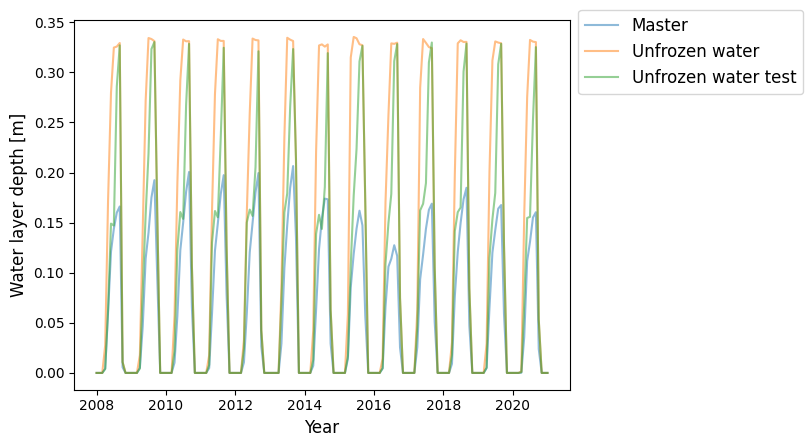

In [130]:
VAR = 'WATERTAB'
date_start = pd.to_datetime("2010")
date_end = pd.to_datetime("2015")

for i, name in enumerate(f_name):
    plt.plot(monthly[name][VAR][date_start:date_end], alpha = 0.5, label=name)

plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel(f"Water layer depth [{units['ALD']}]", fontsize=12)
plt.show()

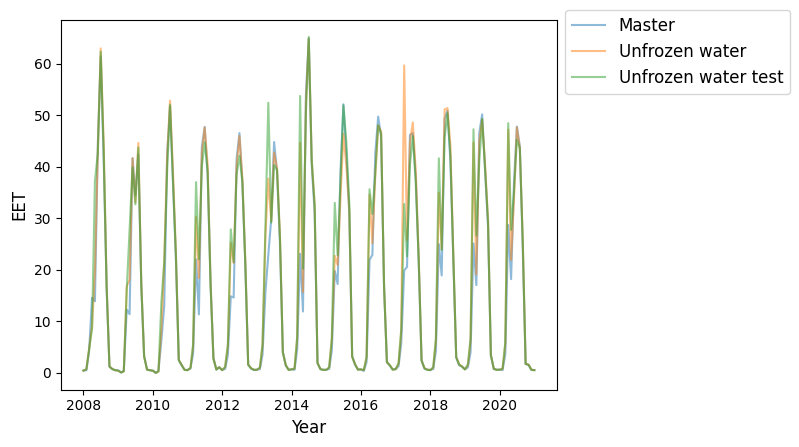

In [131]:
VAR = 'EET'
date_start = pd.to_datetime("2010")
date_end = pd.to_datetime("2015")

for i, name in enumerate(f_name):
    plt.plot(monthly[name][VAR][date_start:date_end], alpha = 0.5, label=name)

plt.legend(bbox_to_anchor=(1.0, 1.05), loc="upper left", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylabel(f"{VAR}", fontsize=12)
plt.show()

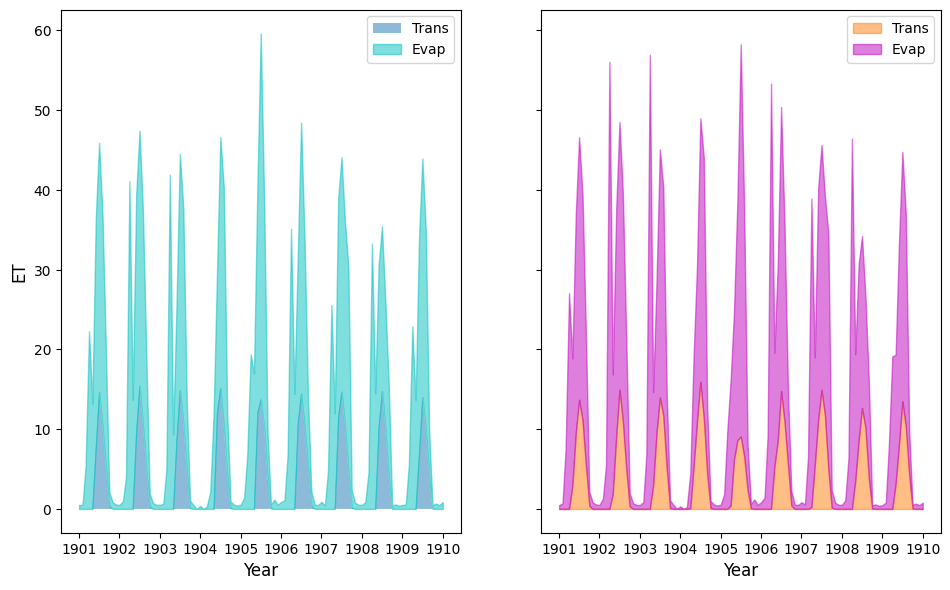

In [132]:
date_start = pd.to_datetime("2010")
date_end = pd.to_datetime("2015")

fig, ax = plt.subplots(1,2, sharey=True)

ax[0].fill_between(monthly[f_name[0]]['TRANSPIRATION'][date_start:date_end].index,
                 np.zeros(len(monthly[f_name[0]]['TRANSPIRATION'][date_start:date_end])),
                 monthly[f_name[0]]['TRANSPIRATION'][date_start:date_end], alpha=0.5, label='Trans')

ax[0].fill_between(monthly[f_name[0]]['TRANSPIRATION'][date_start:date_end].index,
                 monthly[f_name[0]]['TRANSPIRATION'][date_start:date_end],
                 monthly[f_name[0]]['EET'][date_start:date_end], alpha=0.5, color='c', label='Evap')

ax[0].legend(loc='upper right')
ax[0].set_ylabel('ET', fontsize=12)
ax[0].set_xlabel('Year', fontsize=12)

ax[1].fill_between(monthly[f_name[1]]['TRANSPIRATION'][date_start:date_end].index,
                 np.zeros(len(monthly[f_name[1]]['TRANSPIRATION'][date_start:date_end])),
                 monthly[f_name[1]]['TRANSPIRATION'][date_start:date_end], alpha=0.5, color='C1', label='Trans')

ax[1].fill_between(monthly[f_name[1]]['TRANSPIRATION'][date_start:date_end].index,
                 monthly[f_name[1]]['TRANSPIRATION'][date_start:date_end],
                 monthly[f_name[1]]['EET'][date_start:date_end], alpha=0.5, color='m', label='Evap')

ax[1].legend(loc='upper right')
ax[1].set_xlabel('Year', fontsize=12)

plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.2, wspace=None, hspace=None)

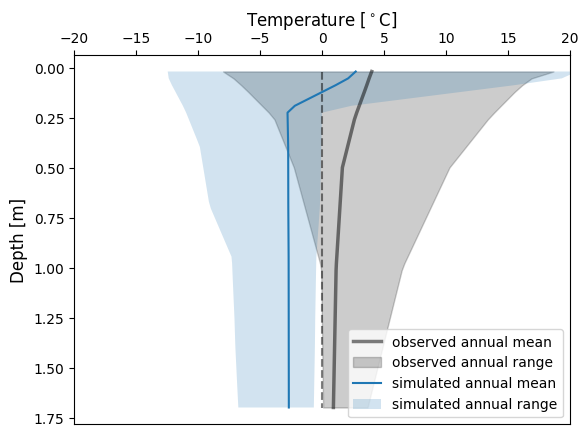

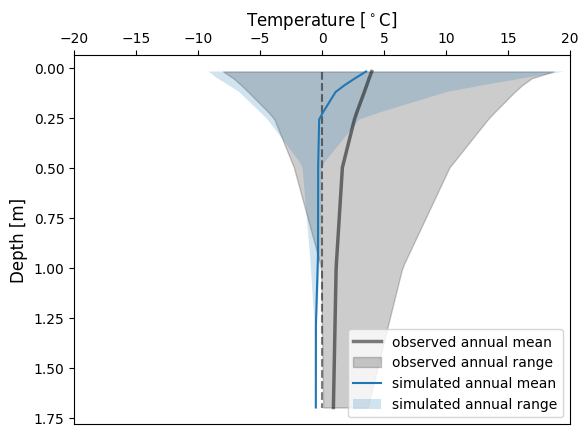

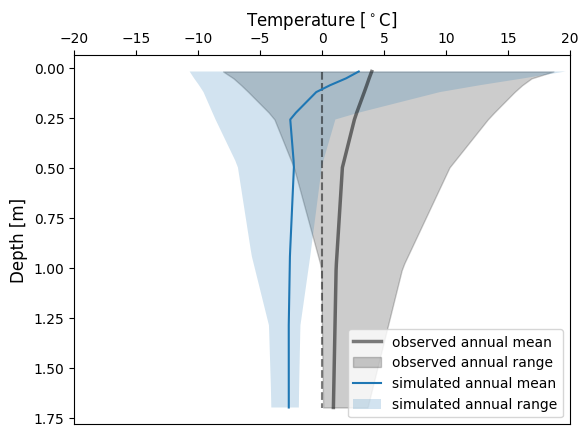

In [133]:
time_range = ['2010-01-01', '2015-12-01'] 
startyr, endyr = time_range[0], time_range[1]  

resolution = 50

for i, run in enumerate(f_name):
    
    fig, ax = plt.subplots()
    
    x, mean, std, mn, mx = seasonal_profile(layer_data["TLAYER"][i],
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            resolution, time_range, 
                                            ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                                            x)
    years = layer_data["TLAYER"][i][time_range[0]:time_range[1]].index.year
    
    ax.plot(mean, x, label="simulated annual mean")
    ax.fill_betweenx(x, mn, mx, alpha=0.2, label="simulated annual range")
    ax.set_xlim(-20, 20)

    plt.legend(loc="lower right", fontsize=10)

    ax.xaxis.tick_top()
    ax.set_xlabel(f"Temperature [$^\circ$C]", fontsize=12)
    ax.xaxis.set_label_position('top') 

    ax.set_ylabel(f"Depth [m]", fontsize=12)
    ax.invert_yaxis()

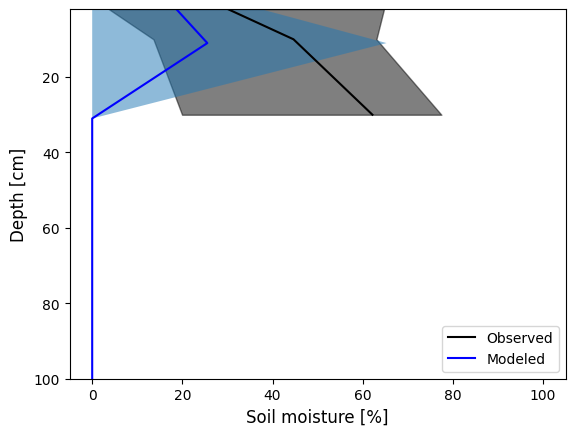

In [134]:
time_range = ['2010-01-01', '2015-12-01'] 
startyr, endyr = time_range[0], time_range[1]  

resolution = 50

for i, run in enumerate(f_name):
    
    fig, ax = plt.subplots()
    
    x, mean, std, mn, mx = seasonal_profile(layer_data["LWCLAYER"][i]*100,
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            resolution, time_range, 
                                            ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
                                            x)
    years = layer_data["LWCLAYER"][i][time_range[0]:time_range[1]].index.year
    
    ax.plot(mean, x, label="simulated annual mean")
    ax.fill_betweenx(x, mn, mx, alpha=0.2, label="simulated annual range")
    ax.set_xlim(-10, 100)

    plt.legend(loc="lower right", fontsize=10)

    ax.xaxis.tick_top()
    ax.set_xlabel(f"Moisture [%]", fontsize=12)
    ax.xaxis.set_label_position('top') 

    ax.set_ylabel(f"Depth [m]", fontsize=12)
    ax.invert_yaxis()